In [24]:
from lightfm import LightFM
import pandas as pd
import numpy as np
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
import matplotlib.pyplot as plt
%matplotlib inline

# 1, load and explore data 

In [3]:
# Load the MovieLens 100k dataset. Only five , star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

In [6]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 19048 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 2153 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [11]:
# show data info
for key,value in data.items():
    print(key,type(value),value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [14]:
# show 100 columns of test data 
data['test'].todense()[:1,:100]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [17]:
# transform data format for explore
# 每行为一个用户，每列为一部电影
data_train = pd.DataFrame(data['train'].todense(),columns=[data['item_labels']])
print(data_train.head())
print('----------------------')

  Toy Story (1995) GoldenEye (1995) Four Rooms (1995) Get Shorty (1995)  \
0              5.0              0.0               0.0               0.0   
1              0.0              0.0               0.0               0.0   
2              0.0              0.0               0.0               0.0   
3              0.0              0.0               0.0               0.0   
4              0.0              0.0               0.0               0.0   

  Copycat (1995) Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)  \
0            0.0                                                5.0     
1            0.0                                                0.0     
2            0.0                                                0.0     
3            0.0                                                0.0     
4            0.0                                                0.0     

  Twelve Monkeys (1995) Babe (1995) Dead Man Walking (1995)  \
0                   0.0         0.0            

In [18]:
# 宽表转换为长表，用.transpose() 转置
# 每行表示一部电影，每列是一个用户
data_train_trans_df = data_train.transpose()
data_train_trans_df.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
Toy Story (1995),5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
GoldenEye (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
Four Rooms (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Get Shorty (1995),0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Copycat (1995),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
a = [1.0,2.1,2.3,4.0]
a[:3][::-1]

[2.3, 2.1, 1.0]

Text(0.5, 0, 'count of item')

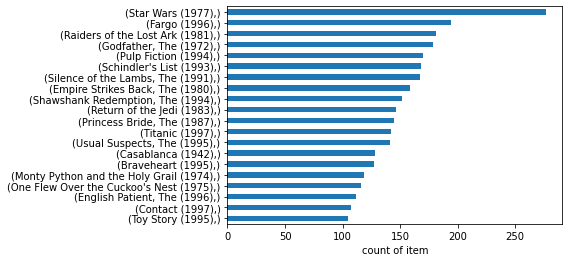

In [23]:
# 计算评分最多的电影
def count_label(x):
    if x > 0:
        return True
    else:
        return False

item_count = data_train_trans_df.applymap(count_label).sum(axis=1)
item_count.sort_values(ascending = False)[:20][::-1].plot.barh()
plt.xlabel('count of item')

# 2, train FM model

## 2.1  using warp as loss

In [4]:
# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'],epochs=30,num_threads=2)

In [28]:
# Evaluate the trained model
train_precision = precision_at_k(model,data['train'],k=5).mean()
test_precision = precision_at_k(model,data['test'],k=5).mean()
print('train precision : {:.2f}'.format(train_precision))
print('test precision : {:.2f}'.format(test_precision))

train precision : 0.39
test precision : 0.05


In [30]:
train_auc = auc_score(model,data['train']).mean()
test_auc = auc_score(model,data['test']).mean()
print('train auc score: {:.2f}'.format(train_auc))
print('test auc score : {:.2f}'.format(test_auc))

train auc score: 0.97
test auc score : 0.92


## 2.2 using bpr as loss

In [31]:
# Instantiate and train the model
model2 = LightFM(loss='bpr')
model2.fit(data['train'],epochs=30,num_threads=2)

In [32]:
# Evaluate the trained model
train_precision = precision_at_k(model2,data['train'],k=5).mean()
test_precision = precision_at_k(model2,data['test'],k=5).mean()
print('train precision : {:.2f}'.format(train_precision))
print('test precision : {:.2f}'.format(test_precision))
print('-----------------')
train_auc = auc_score(model2,data['train']).mean()
test_auc = auc_score(model2,data['test']).mean()
print('train auc score: {:.2f}'.format(train_auc))
print('test auc score : {:.2f}'.format(test_auc))

train precision : 0.45
test precision : 0.04
-----------------
train auc score: 0.93
test auc score : 0.80


# 3, generate recommendations for user

### using 'warp' as loss because better performance

In [47]:
n_users, n_movies = data['train'].shape
score = model.predict(1,np.arange(n_movies))
print(score)

[-0.22396916 -2.65647864 -2.15828228 ... -2.09169221 -2.04696894
 -1.94796824]


In [50]:
a = [-1.1,-2.3,-3.3]
np.argsort(a)

array([2, 1, 0])

In [51]:
def recommendation(model,data,user_ids):
    n_users,n_movies = data['train'].shape
    # find items user interacted
    
    for user_id in user_ids:
        seen_movies = data['item_labels'][data['train'].tocsr()[user_ids].indices]
        score = model.predict(user_id,np.arange(n_movies))
        top_movies = data['item_labels'][np.argsort(-score)] 
        print('user_id:',user_id)
        print('user seen movies:')
        
        for movie in seen_movies[:3]:
            print(movie)
            
        print('user top movies:')
        for movie in top_movies[:3]:
            print(movie)
    

In [52]:
recommendation(model,data,[0,10,20])

user_id: 0
user seen movies:
Toy Story (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Dead Man Walking (1995)
user top movies:
Fargo (1996)
Close Shave, A (1995)
Usual Suspects, The (1995)
user_id: 10
user seen movies:
Toy Story (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Dead Man Walking (1995)
user top movies:
Star Wars (1977)
English Patient, The (1996)
Toy Story (1995)
user_id: 20
user seen movies:
Toy Story (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Dead Man Walking (1995)
user top movies:
Fargo (1996)
Twelve Monkeys (1995)
Pulp Fiction (1994)
